In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy

0.010101010101010102
-291.5802025794983


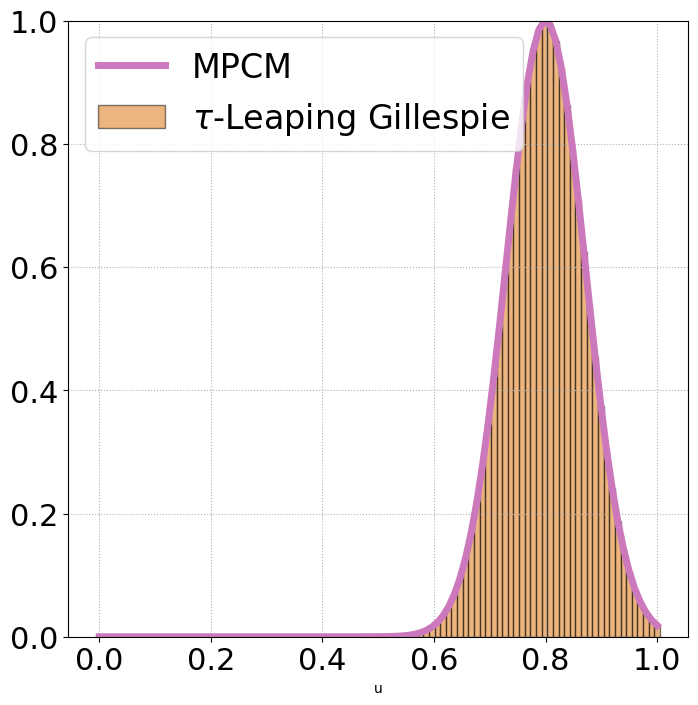

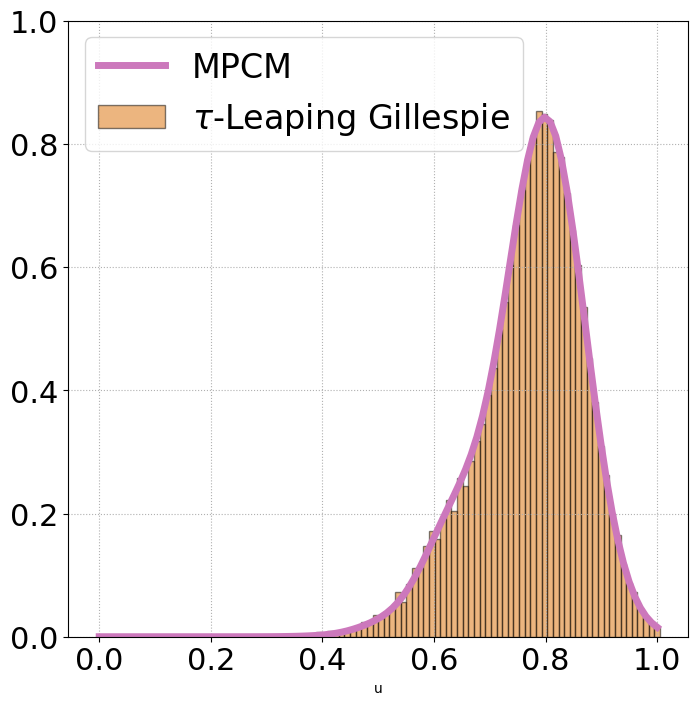

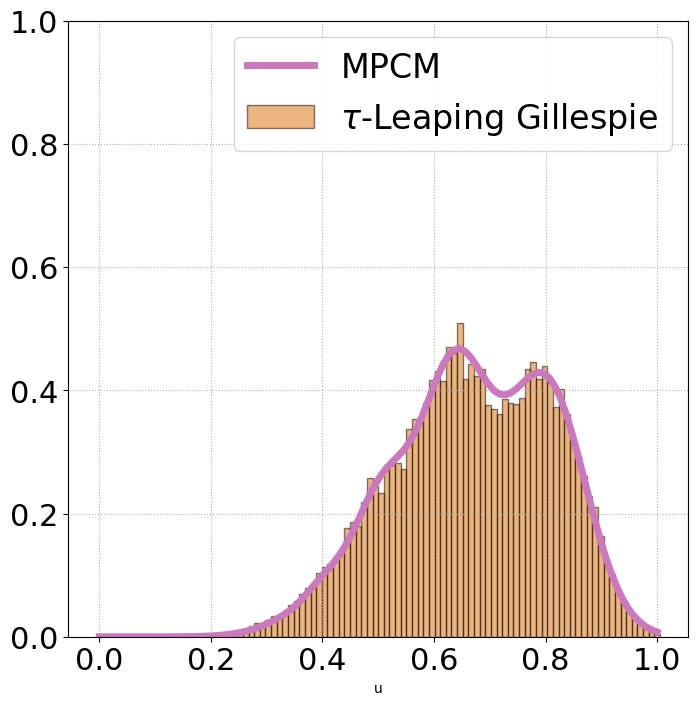

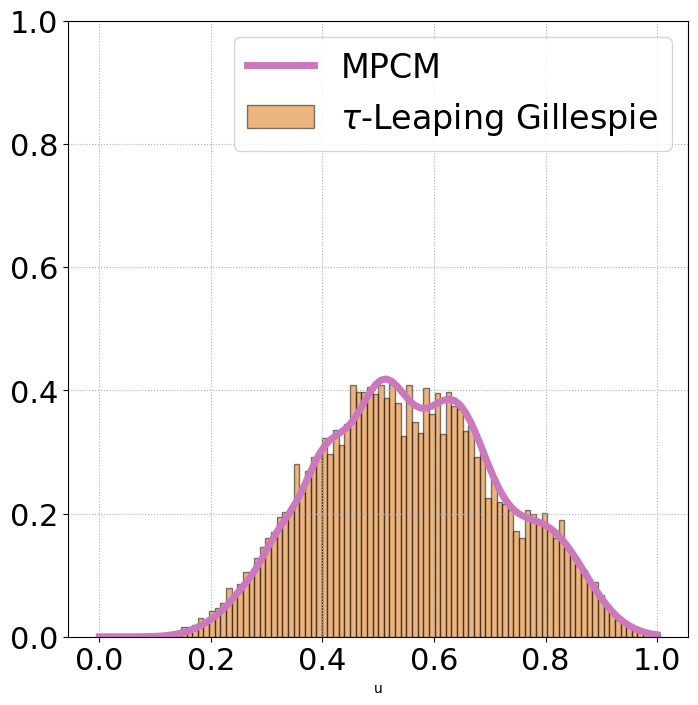

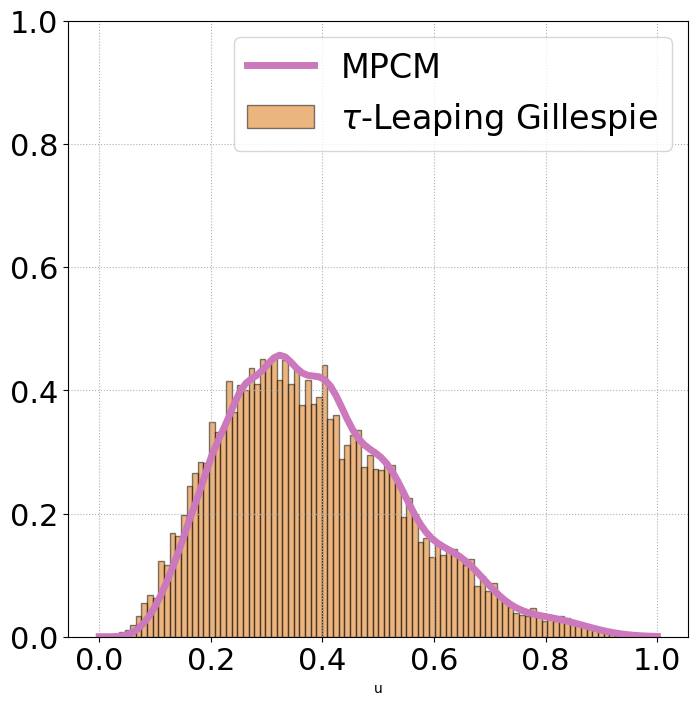

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import PyKinetic as pk
import seaborn as sns
KS2parts = pk.KineticSystem(2)
TransitionLeft= pk.TransitionLeft(0.4)
# TransitionRight= pk.TransitionRight(0.4)
KS2parts.AddInteraction(1,2,1, pk.OneFunc, TransitionLeft) 
KS2parts.Interpolate(InterpolationNodesNumber = 100)
start_time = time.time()
mean1  = 0.8
std1 = 0.01
mean2 = 0.5
std2 = 0.01
def init1(x):
    # print(x)
    return np.exp(-(x-mean1)**2/std1 )
def init2(x):
    return np.exp(-(x-mean2)**2/std2)

KS2parts.Solve([init1, init2], limit_time= 20)
# Grid and Parameters
n = 100
u = np.linspace(0, 1, n)
Δu = u[1] - u[0]
print(Δu)
gamma = .4
tau = 0.001
T_max = 20.0
steps = int(T_max / tau)
tausteps = steps
# Exact initial distributions (unnormalized)
f1_density = np.exp(-((u - 0.8)**2) / 0.01)
f2_density = np.exp(-((u - 0.5)**2) / 0.01)

# Initialize particle numbers based on f1_density (continuous → discrete)
F1 = np.round(f1_density * 1000).astype(int)  # use a scaling factor for resolution
f2 = f2_density.copy()  # used in continuous form in propensities

# Precompute phi(x, y) = x - γ x y → target bin index
phi_map = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(n):
        x, y = u[i], u[j]
        phi = x - gamma * x * y
        phi_clipped = np.clip(phi, 0.0, 1.0)
        k = int(np.clip(np.floor(phi_clipped / Δu), 0, n - 1))
        phi_map[i, j] = k

# Store simulation history
history = [F1.copy()]

# Tau-leaping loop
for step in range(steps):
    gain = np.zeros(n, dtype=int)
    new_F1 = F1.copy()

    for i in range(n):
        if F1[i] == 0:
            continue
        for j in range(n):
            rate = F1[i] * f2[j] * Δu  # a_{ij} = f1_i * f2_j * Δu
            n_react = np.random.poisson(rate * tau)
            n_react = min(n_react, new_F1[i])  # don't remove more than available
            new_F1[i] -= n_react
            gain[phi_map[i, j]] += n_react

    F1 = new_F1 + gain
    history.append(F1.copy())
print(start_time - time.time())
# Convert to densities for plotting
history = np.array(history)
tauhist = copy.copy(history)
density_history = history / Δu  # approximate density per bin

pallette = sns.color_palette("colorblind", n_colors=8)
tplot = [0,1,5,10,20]
for t in tplot:
    plt.figure(figsize=(8, 8))
    # print(t,int(t*(steps-1)/T_max) )
    final_counts = history[int(t*(steps-1)/T_max)]
    density = final_counts /1000
    colpal = ["#004949","#009292","#ffb6db",
                     "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
                     "#920000","#924900","#db6d00","#24ff24","#ffff6d"]
    plt.bar(u, density, width=Δu,edgecolor = 'black',  alpha=0.5, color = colpal[10], label=r'$\tau$-Leaping Gillespie')
    plt.plot(u, KS2parts.InterpolateArray(1,u,t),   color = pallette[4], linewidth=5, label = 'MPCM')
    plt.xlabel('u')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(fontsize = 24)
    plt.ylim(0, 1) 
    plt.grid(linestyle='dotted')
    # plt.savefig(f'tauleaping comparaison/tauleapingleft_1sim_comparaisont={t}.jpg', dpi=200)
    plt.show()

345.55078196525574
0 0


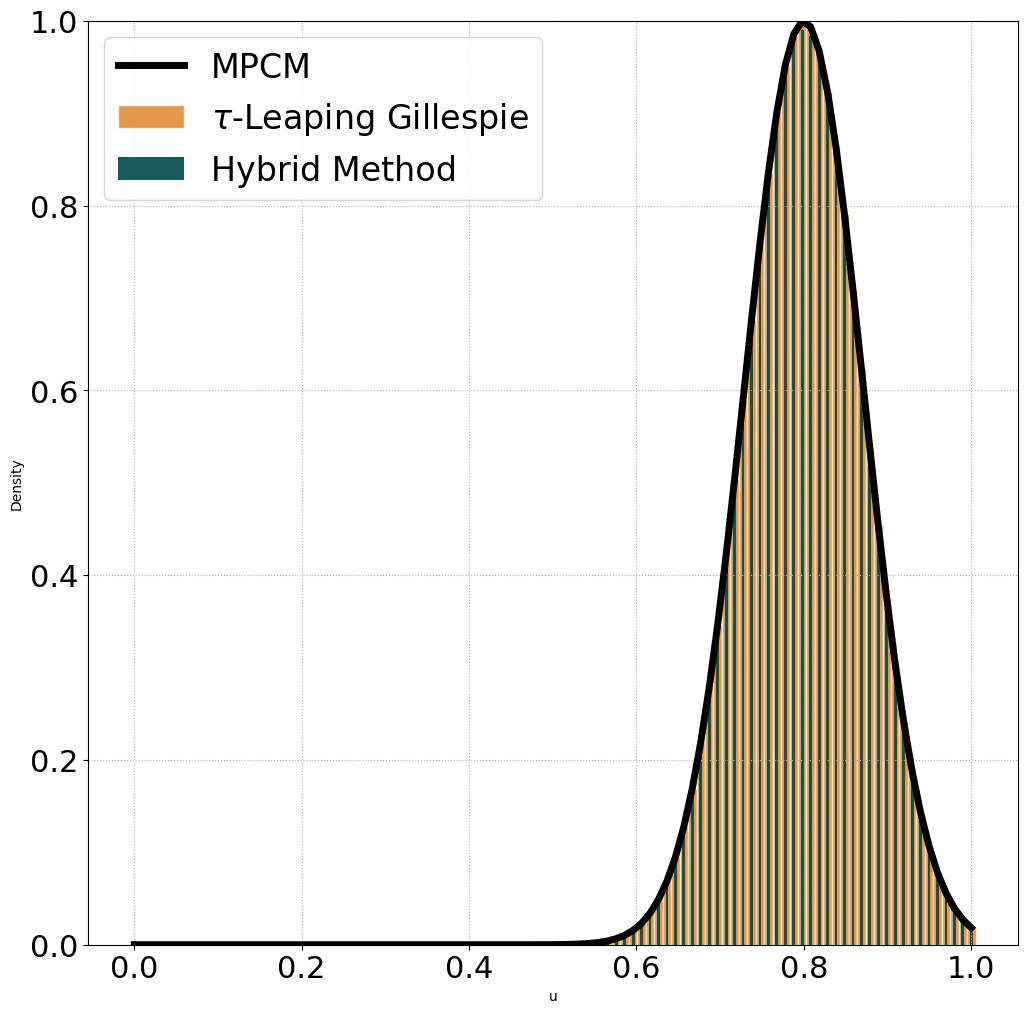

1 999


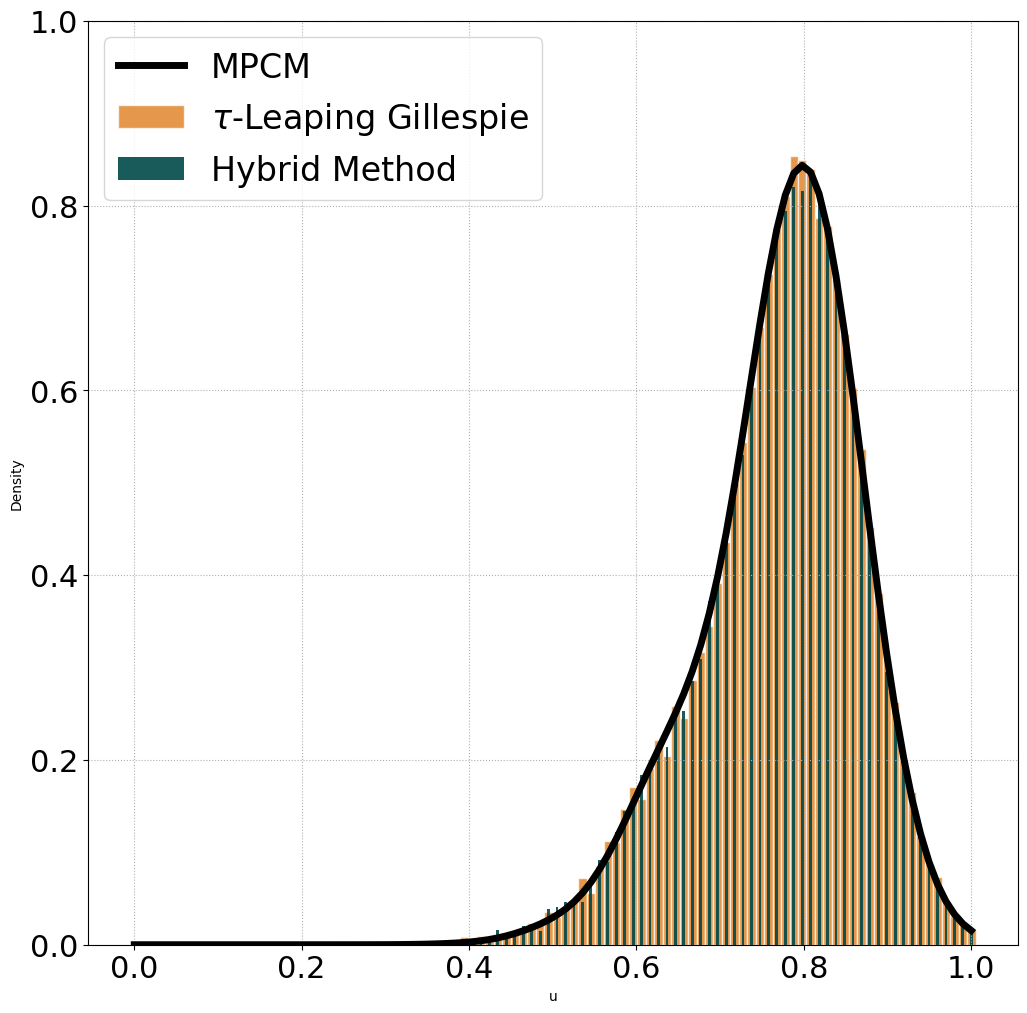

5 4999


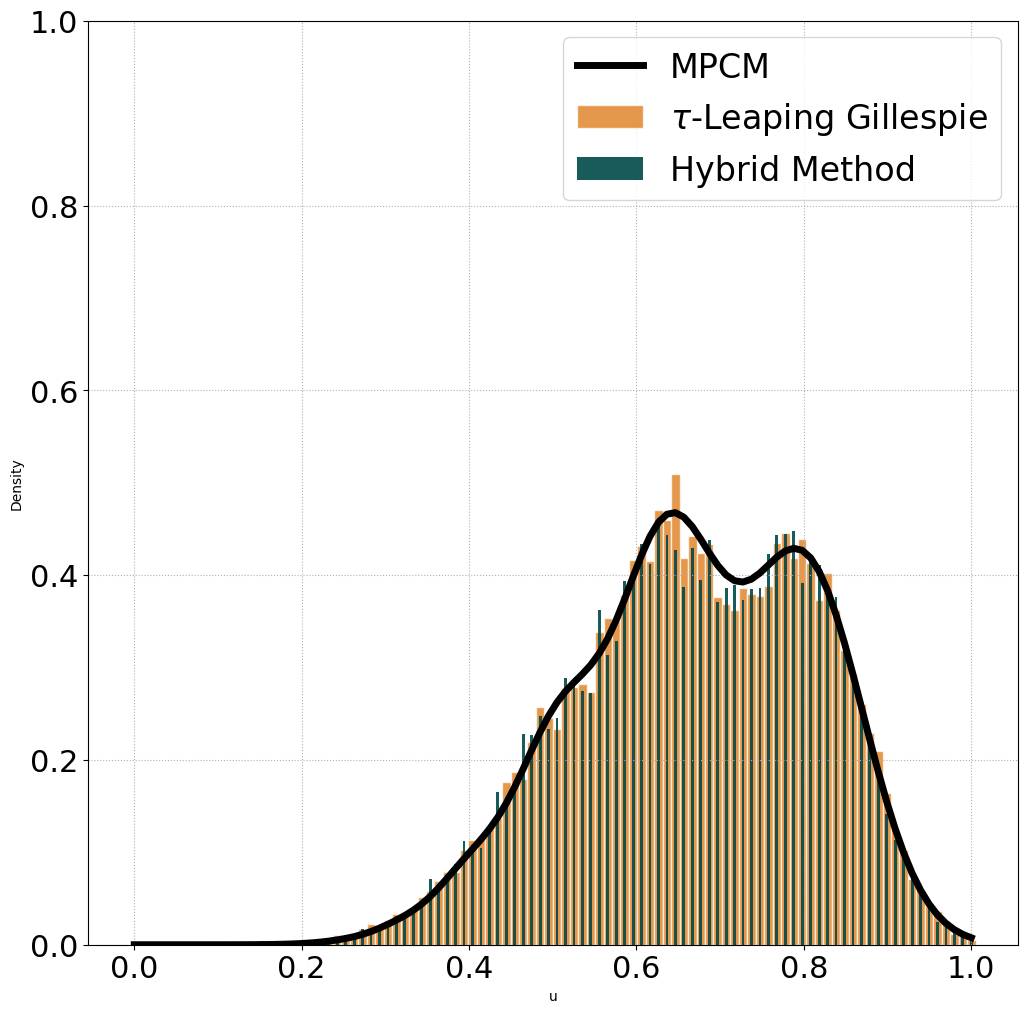

10 9999


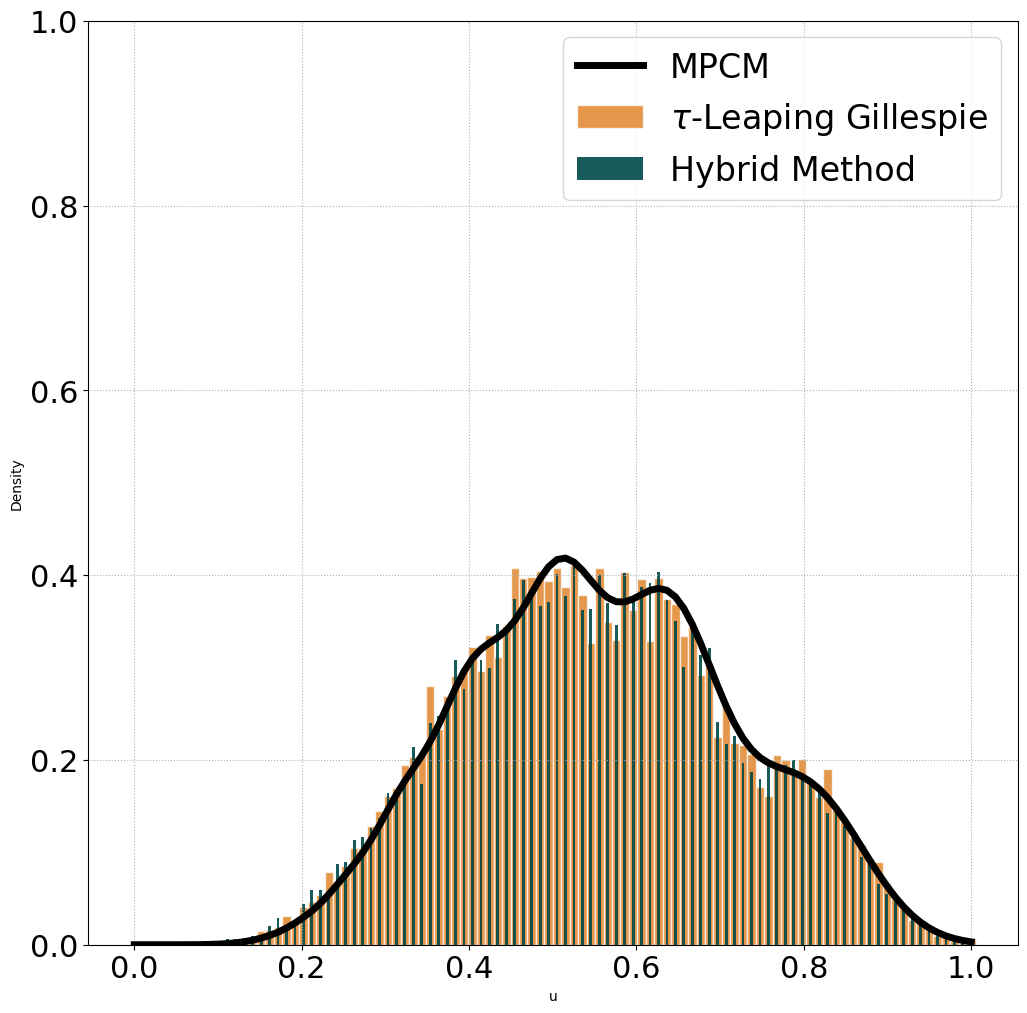

20 19999


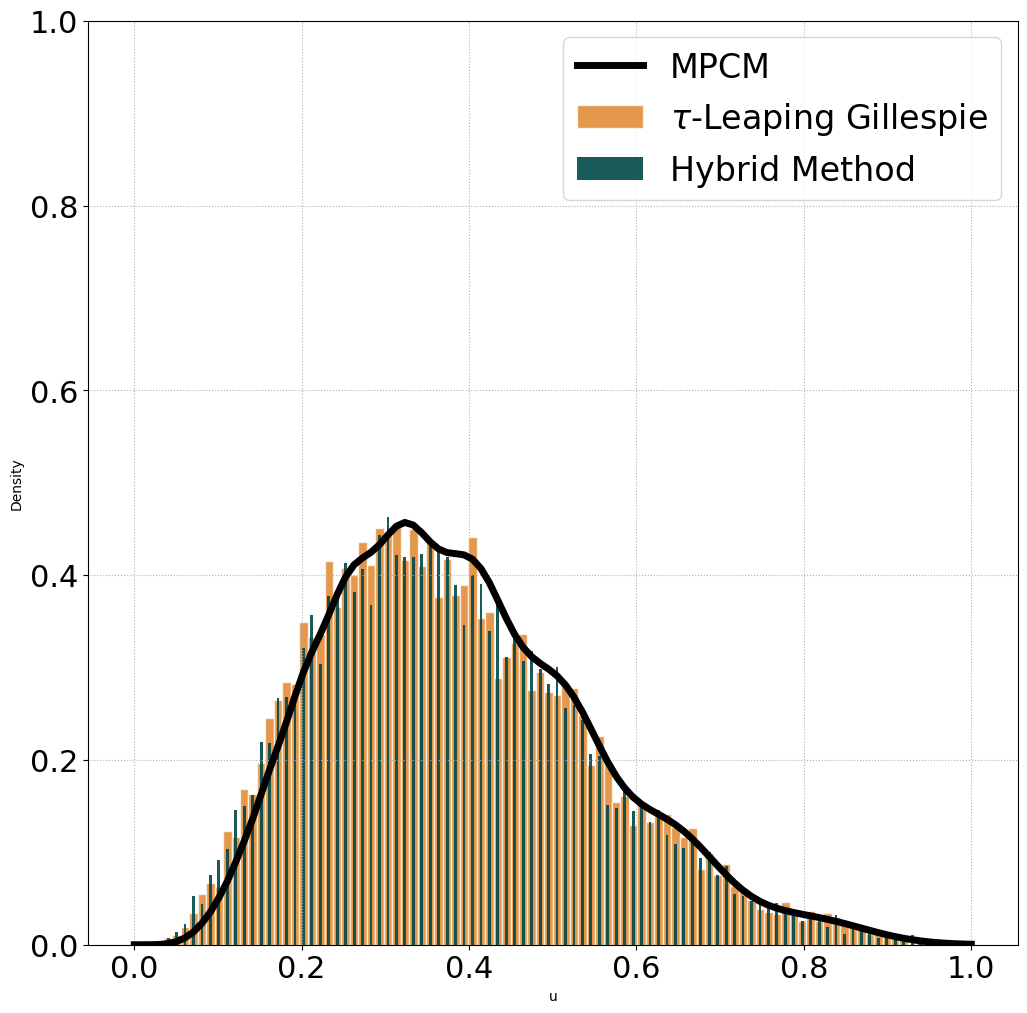

In [7]:

import numpy as np
import matplotlib.pyplot as plt

# Parameters
start_time = time.time()
n = 100
u = np.linspace(0, 1, n)
Δu = u[1] - u[0]
gamma = 0.4
tau = 0.001
T_max = 20.0
steps = int(T_max / tau)
deterministic_threshold = 1000  # switch from stochastic to deterministic

# Initialize f₁ and f₂
f1_density = np.exp(-((u - 0.8) ** 2) / 0.01)
f2_density = np.exp(-((u - 0.5) ** 2) / 0.01)

# Normalize densities to their total mass (optional)
# f1_density /= np.sum(f1_density) * Δu
# f2_density /= np.sum(f2_density) * Δu

# Discretize particle representation of f₁
F1 = np.round(f1_density * 1_000).astype(int)
f2 = f2_density.copy()

# Precompute φ(x, y) mapping to index
phi_map = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(n):
        x, y = u[i], u[j]
        phi = x - gamma * x * y
        phi_clipped = np.clip(phi, 0.0, 1.0)
        k = int(np.clip(np.floor(phi_clipped / Δu), 0, n - 1))
        phi_map[i, j] = k

# Store simulation history
history = [F1.copy()]

# Main hybrid simulation loop
for step in range(steps):
    gain = np.zeros(n)
    loss = np.zeros(n)

    new_F1 = F1.copy().astype(float)  # Allow deterministic updates
    for i in range(n):
        if F1[i] == 0:
            continue
        for j in range(n):
            rate = F1[i] * f2[j] * Δu
            if F1[i] < deterministic_threshold:
                # Stochastic update
                n_react = np.random.poisson(rate * tau)
                n_react = min(n_react, new_F1[i])
                new_F1[i] -= n_react
                gain[phi_map[i, j]] += n_react
            else:
                # Deterministic update
                dN = rate * tau
                new_F1[i] -= dN
                gain[phi_map[i, j]] += dN

    F1 = (new_F1 + gain).astype(int)
    history.append(F1.copy())

# Convert history to density
history = np.array(history)
density_history = history / Δu

# # Plotting
# plt.figure(figsize=(8, 8))
# plt.plot(u, density_history[-1]/100000, label='Final f1')
# # plt.plot(u, density_history[0]/100000, '--', label='Initial f1')
# # plt.plot(u, f2 , ':', label='f2 (static)')
# plt.xlabel("u")
# plt.ylabel("Density")
# plt.title("Hybrid Gillespie (tau-leaping) with Deterministic Switch")
# plt.legend()
# plt.grid(True)
# plt.show()
print(time.time()-start_time)
tplot = [0,1,5,10,20]
for t in tplot:
    plt.figure(figsize=(12, 12))
    print(t,int(t*(steps-1)/T_max) )
    colpal = ["#004949","#009292","#ffb6db",
                     "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
                     "#920000","#924900","#db6d00","#24ff24","#ffff6d"]
    final_counts = tauhist[int(t*(steps-1)/T_max)]
    density = final_counts /1000
    plt.bar(u, density, width=Δu,edgecolor = 'white',  alpha=0.7, color = colpal[10], label=r'$\tau$-Leaping Gillespie')
    final_counts = history[int(t*(steps-1)/T_max)]
    density = final_counts / Δu/100000
    
    
    plt.bar(u, density, width=Δu/3,  alpha=0.9, color = colpal[0], label=r'Hybrid Method')
    plt.plot(u, KS2parts.InterpolateArray(1,u,t),   color = 'black', linewidth=5, label = 'MPCM')
    # plt.plot(u, f1_density, '--k', label='Initial $f_1(u)$')
    # plt.plot(u, f2_density, ':r', label='Fixed $f_2(u)$')
    plt.xlabel('u')
    plt.ylabel('Density')
    # plt.title('Final State of $f_1(t,u)$ as Histogram')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(fontsize = 24)
    plt.ylim(0, 1) 
    plt.grid(linestyle='dotted')
    plt.savefig(f'tauleaping comparaison/tauHybrifleft_1sim_comparaisont={t}.jpg', dpi=200)
    plt.show()
